In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [2]:
torch.manual_seed(424242)

--------------------------------------------------------------------------------------------------------------------------------
###                                      Generation of Data      -         Synthetic Data
--------------------------------------------------------------------------------------------------------------------------------

In [3]:
# parameters of the (latent) gaussians
mus = (np.array([-2., -2.]), np.array([2., 2.]))
covs = (
    np.array([[0.5, 0.],[0., 0.5]]),
    np.array([[0.3, 0.1], [0.1, 0.3]]),
)

In [4]:
n_features = 2
n_classes = len(mus)
n_samples_per_class = 10000

features = []
labels = []

for i in range(n_classes):
    features.append(
        np.random.multivariate_normal(mean=mus[i], 
                                      cov=covs[i],
                                      size=(n_samples_per_class,))
    )
    labels.append([i]*n_samples_per_class)

In [5]:
features_orig = np.array(features).reshape(n_classes*n_samples_per_class, n_features)
labels_orig = np.array(labels).reshape(n_classes*n_samples_per_class, 1).squeeze()

## View latent dataset

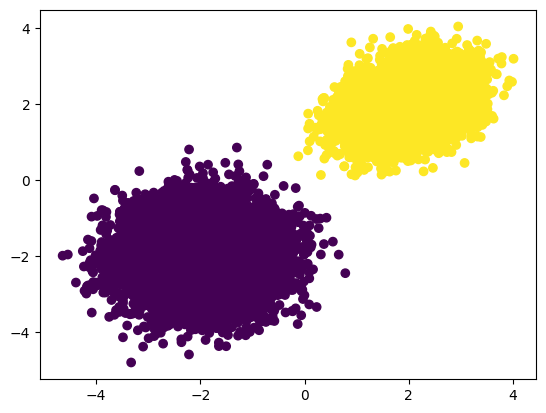

In [6]:
plt.scatter(
    features_orig[:,0], features_orig[:,1], c=labels_orig
)

In [7]:
labels_orig.shape

(20000,)

In [8]:
def warp1(a):
    x = a[:,0]
    y = a[:,1]
    out1 = x*y
    out2 = x + np.exp(-y/10.)
    out3 = (np.log(x*x*y*y) + 10*x*x*y - x)/100.
    return np.stack((out1, out2, out3), axis=-1)

In [9]:
def warp2(a):
    x = a[:,0]
    y = a[:,1]
    out1 = np.log(x*x*y*y) + 10*x*y*np.sin(x)
    out2 = y - 10*x*y
    out3 = x*y*np.tan(y)
    return np.stack((out1, out2, out3), axis=-1)

In [10]:
warped_features_1 = warp1(features_orig)
warped_features_2 = warp2(features_orig)

In [11]:
warped_features_2.shape

(20000, 3)

## View dataset for client 1

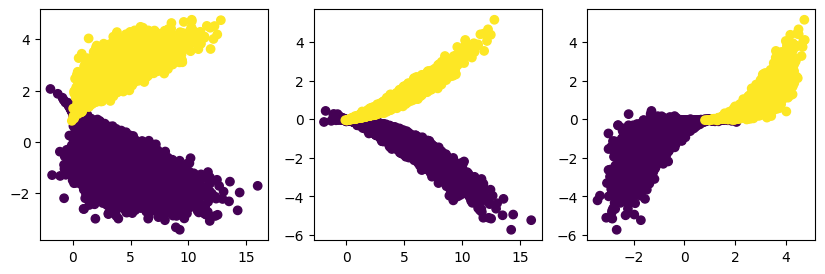

In [12]:
fig, ax = plt.subplots(1,3,figsize=(10,3))
ax[0].scatter(
    warped_features_1[:,0], warped_features_1[:,1], c=labels_orig
)
ax[1].scatter(
    warped_features_1[:,0], warped_features_1[:,2], c=labels_orig
)
ax[2].scatter(
    warped_features_1[:,1], warped_features_1[:,2], c=labels_orig
)

## View dataset for client 2

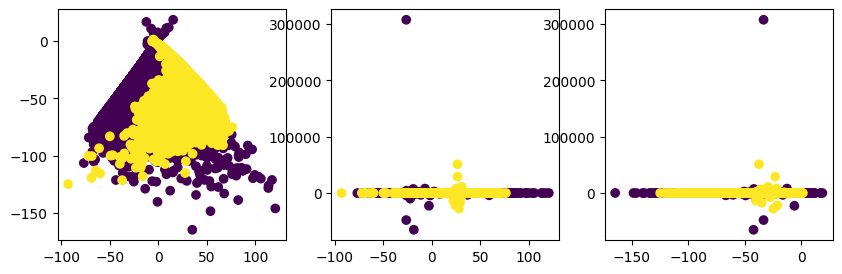

In [13]:
fig, ax = plt.subplots(1,3,figsize=(10,3))
ax[0].scatter(
    warped_features_2[:,0], warped_features_2[:,1], c=labels_orig
)
ax[1].scatter(
    warped_features_2[:,0], warped_features_2[:,2], c=labels_orig
)
ax[2].scatter(
    warped_features_2[:,1], warped_features_2[:,2], c=labels_orig
)

### Clients

### Preparing the data

In [14]:
X_train_C1, X_test_C1, y_train_C1, y_test_C1 = train_test_split(torch.tensor(warped_features_1), torch.tensor(labels_orig), test_size=0.2, random_state=42)
X_train_C2, X_test_C2, y_train_C2, y_test_C2 = train_test_split(torch.tensor(warped_features_2), torch.tensor(labels_orig), test_size=0.2, random_state=42)

In [15]:
X_train_all_C1 = torch.utils.data.TensorDataset(torch.tensor(np.vstack(X_train_C1)), torch.tensor(np.hstack(y_train_C1)))
X_test_all_C1 = torch.utils.data.TensorDataset(torch.tensor(np.vstack(X_test_C1)), torch.tensor(np.hstack(y_test_C1)))

In [16]:
X_train_all_C2 = torch.utils.data.TensorDataset(torch.tensor(np.vstack(X_train_C2)), torch.tensor(np.hstack(y_train_C2)))
X_test_all_C2 = torch.utils.data.TensorDataset(torch.tensor(np.vstack(X_test_C2)), torch.tensor(np.hstack(y_test_C2)))

In [17]:
trainloader_C1= torch.utils.data.DataLoader(X_train_all_C1, batch_size=64, shuffle=True, num_workers=2)
testloader_C1 = torch.utils.data.DataLoader(X_test_all_C1, batch_size=64, shuffle=False, num_workers=2)

In [18]:
trainloader_C2 = torch.utils.data.DataLoader(X_train_all_C2, batch_size=64, shuffle=True, num_workers=2)
testloader_C2 = torch.utils.data.DataLoader(X_test_all_C2, batch_size=64, shuffle=False, num_workers=2)

In [19]:
for images, labels in testloader_C1:
    print(images.shape, labels.shape)
    break

torch.Size([64, 3]) torch.Size([64])


In [20]:
for images, labels in testloader_C2:
    print(images.shape, labels.shape)
    break

torch.Size([64, 3]) torch.Size([64])


### Training

### ------------------------------------------------------------------SplitNN---------------------------------------------------------------------------------

In [21]:
class Client1():
    def __init__(self):
        self.model = nn.Sequential(nn.Linear(3, 20, dtype=torch.float64),
                                   nn.ReLU(),
                                   nn.Linear(20, 10, dtype=torch.float64),
                                   nn.ReLU())

        self.optimizer = optim.SGD(self.model.parameters(), lr=1e-2, momentum=0.)
        self.last_logits = None

    def split_forward(self, batch): 
        self.optimizer.zero_grad()
        self.last_logits = self.model(batch)
        self.last_logits.retain_grad()
        latent_parameters = list(self.model.parameters())
        return self.last_logits.detach(), latent_parameters
    
    def split_backward(self, split_grad):
        self.last_logits.backward(split_grad)
        
    def update(self, latent_parameters):
        # Get the parameters of the latent model
        latent_params = self.model.parameters()
    
        # Iterate over the parameters and update them with new values
        for param, new_value in zip(latent_params, latent_parameters):
            param.data.copy_(new_value)
        
    def debug_print(self):
        #print('#####################')
        #for name, param in self.model.named_parameters():
            #print(f"{name}")
            #print(f"{param[:1]}")
            #print(f"{param.grad if param.grad is None else param.grad[:1]}")
        #print(f"last logits {self.last_logits[0,0,0,:5]}"
              #f"grad {self.last_logits.grad if self.last_logits.grad is None else self.last_logits.grad[0,0,0,:5]}")
        print('#####################')

In [22]:
class Client2():
    def __init__(self):
        self.model = nn.Sequential(nn.Linear(3, 20, dtype=torch.float64),
                                   nn.ReLU(),
                                   nn.Linear(20, 10, dtype=torch.float64),
                                   nn.ReLU())

        self.optimizer = optim.SGD(self.model.parameters(), lr=1e-2, momentum=0.)
        self.last_logits = None

    def split_forward(self, batch): 
        self.optimizer.zero_grad()
        self.last_logits = self.model(batch)
        self.last_logits.retain_grad()
        latent_parameters = list(self.model.parameters())
        return self.last_logits.detach(), latent_parameters
    
    def split_backward(self, split_grad):
        self.last_logits.backward(split_grad)
        
    def update(self, latent_parameters):
        # Get the parameters of the latent model
        latent_params = self.model.parameters()
    
        # Iterate over the parameters and update them with new values
        for param, new_value in zip(latent_params, latent_parameters):
            param.data.copy_(new_value)
        
    def debug_print(self):
        #print('#####################')
        #for name, param in self.model.named_parameters():
            #print(f"{name}")
            #print(f"{param[:1]}")
            #print(f"{param.grad if param.grad is None else param.grad[:1]}")
        #print(f"last logits {self.last_logits[0,0,0,:5]}"
              #f"grad {self.last_logits.grad if self.last_logits.grad is None else self.last_logits.grad[0,0,0,:5]}")
        print('#####################')

In [23]:
client1_Split = Client1()
client2_Split = Client2()
class Server():
    def __init__(self):
        self.model = nn.Sequential(nn.Linear(10, 8, dtype=torch.float64),
                                   nn.ReLU(),
                                   nn.Linear(8, 5, dtype=torch.float64),
                                   nn.ReLU(),
                                   nn.Linear(5, 3, dtype=torch.float64),
                                   nn.Softmax(dim=1))

        #self.loss_function1 = nn.CrossEntropyLoss()
        #self.optimizer1 = optim.SGD(self.model.parameters(), lr=1e-2, momentum=0.)
        
        self.loss_function = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.model.parameters(), lr=1e-2, momentum=0.)
        
        
        self.split_logits = None
        self.loss = None
        
        #self.split_logits1 = None
        #self.loss1 = None
    
    def split_forward(self, split_logits, labels):
        self.optimizer.zero_grad()
        
        self.split_logits = split_logits
        #self.split_logits = split_logits
        self.split_logits.requires_grad_(True)
        logits = self.model(self.split_logits)
        self.loss = self.loss_function(logits, labels)
        return logits
    
    def update(self, client1_logits, y_c1, client2_logits, y_c2):
        #Server
        _,  latent_parameters1 =  client1_Split.split_forward(client1_logits)
        _, latent_parameters2 =  client2_Split.split_forward(client2_logits)
        
        latent_parameters =[(x + y) / 2 for x, y in zip(latent_parameters1, latent_parameters2)]
        
        client1_Split.update(latent_parameters)
        client2_Split.update(latent_parameters)
        
    def split_backward(self):
        self.loss.backward()
        return self.split_logits.grad.detach()

In [24]:
server = Server()

#print(list(client.model.parameters())[0][:1])
#print('--')

n_epochs = 5
for i in range(n_epochs):
    for i, ((x_c1, y_c1), (x_c2, y_c2)) in enumerate(zip(trainloader_C1, trainloader_C2)):
        #Clients
        client1_logits, _ = client1_Split.split_forward(x_c1)
        client2_logits, _  = client2_Split.split_forward(x_c2)
        
        #Server
        ser1_logits =  server.split_forward(client1_logits, y_c1.long())
        ser2_logits =  server.split_forward(client2_logits, y_c2.long())
        
        
        split_grad = server.split_backward()
        
        client1_Split.split_backward(split_grad)
        client2_Split.split_backward(split_grad)
        
        client1_Split.optimizer.step()
        client2_Split.optimizer.step()
        
        server.optimizer.step()
    for i, ((x_c1, y_c1), (x_c2, y_c2)) in enumerate(zip(trainloader_C1, trainloader_C2)):
        server.update(x_c1, y_c1.long(), x_c2, y_c2.long())
    break

In [27]:
total_accuracy_1 = 0.0
total_samples_1 = 0

total_accuracy_2 = 0.0
total_samples_2 = 0

for i, ((x_c1, y_c1), (x_c2, y_c2)) in enumerate(zip(testloader_C1, testloader_C2)):
    client1_logits, _ = client1_Split.split_forward(x_c1)
    client2_logits, _ = client2_Split.split_forward(x_c2)
    
    ser_logits1 = server.split_forward(client1_logits, y_c1.long())
    ser_logits2 = server.split_forward(client2_logits, y_c2.long())
        
    _, predictions_1 = torch.max(ser_logits1, 1)
    _, predictions_2 = torch.max(ser_logits2, 1)
        
    acc_1 = torch.mean((predictions_1 == y_c1).float())
    acc_2 = torch.mean((predictions_2 == y_c2).float())
    
    
    total_accuracy_1 += acc_1.item() * x_c1.size(0)
    total_samples_1 += x_c1.size(0)
    
    total_accuracy_2 += acc_2.item() * x_c2.size(0)
    total_samples_2 += x_c2.size(0)

final_accuracy_1 = total_accuracy_1 / total_samples_1
final_accuracy_2 = total_accuracy_2 / total_samples_2
print(f"Accuracy on test set 1: {final_accuracy_1 * 100:.2f}%")
print(f"Accuracy on test set 2: {final_accuracy_2 * 100:.2f}%")

Accuracy on test set 1: 50.48%
Accuracy on test set 2: 42.58%
